In [ ]:
# https://deep-learning-study.tistory.com/368 참고

In [1]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
import subprocess as sp
from PIL import Image

from datetime import datetime

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    
DEVICE = "cuda"

In [2]:
# parameters
RANDOM_SEED = 42 # random seed를 42로 쓰는 건 관습이라고 함 (은하수를 여행하는 히치하이커를 위한 안내서)
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 15

IMG_SIZE = 32
N_CLASSES = 10

In [3]:
def get_accuracy(model, data_loader, device):
    '''
    전체 data_loader에 대한 예측의 정확도를 계산하는 함수
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    '''
    training과 validation loss를 시각화하는 함수
    '''
    
    # plot style을 seaborn으로 설정
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # plot style을 기본값으로 설정
    plt.style.use('default')

In [4]:
# training data에 사용되는 helper 함수

def train(train_loader, model, criterion, optimizer, device):
    '''
    training loop의 training 단계에 대한 함수
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # 순전파
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # 역전파
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [5]:
# validation data에 사용되는 함수 (역전파X)

def validate(valid_loader, model, criterion, device):
    '''
    training loop의 validation 단계에 대한 함수
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # 순전파와 손실 기록하기
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

In [6]:
# training loop 정의

def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    전체 training loop를 정의하는 함수
    '''
    
    # metrics를 저장하기 위한 객체 설정
    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # model 학습하기
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

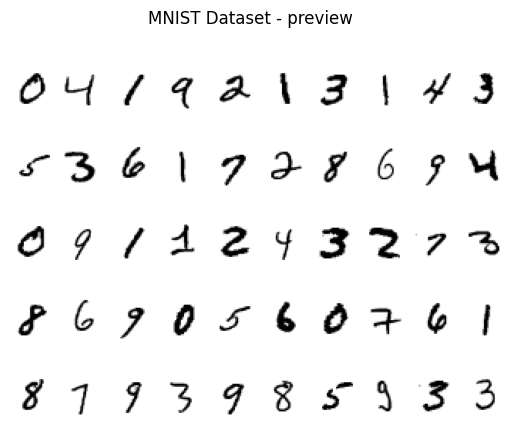

In [7]:
##########################
### MNIST DATASET
##########################

resize_transform = transforms.Compose([transforms.Resize((32, 32)),
                                       transforms.ToTensor()])

# Note transforms.ToTensor() scales input images
# to 0-1 range

# data set 다운받고 생성하기
train_dataset = datasets.MNIST(root='./data', 
                               train=True, 
                               transform=resize_transform,
                               download=True)

valid_dataset = datasets.MNIST(root='./data', 
                              train=False, 
                              transform=resize_transform)

# data loader 정의하기
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)

# 불러온 MNIST data 확인하기
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(train_dataset.data[index], cmap='gray_r')
fig.suptitle('MNIST Dataset - preview');

In [8]:
##########################
### LeNet-5 구조 정의 - default (배치 정규화)
### 활성화 함수: tanh, 출력층 활성화 함수: softmax, 최적화: Adam, 손실함수: 교차엔트로피
##########################

class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        # Sequential: layer을 순서대로 적용
        self.feature_extractor = nn.Sequential(          
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.BatchNorm2d(6),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.BatchNorm2d(16),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.BatchNorm2d(120),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.BatchNorm1d(84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [9]:
##########################
### LeNet-5 구조 정의 - 변형1(논문 그대로 - 풀링계층을 서브샘플링계층으로, C3 layer 변경)
### 활성화 함수: tanh, 활성화 함수: softmax, 최적화: Adam, 손실함수: 교차엔트로피
##########################

import torch
import torch.nn as nn
import torch.nn.functional as F

class SubsamplingLayer(nn.Module):
    def __init__(self, in_channels):
        super(SubsamplingLayer, self).__init__()
        self.in_channels = in_channels
        self.weight = nn.Parameter(torch.Tensor(in_channels))
        self.bias = nn.Parameter(torch.Tensor(in_channels))
        self.sigmoid = nn.Sigmoid()
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.ones_(self.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        out = F.avg_pool2d(x, kernel_size=2) * 4  # Sum over the 2x2 region
        out = out * self.weight.view(1, -1, 1, 1) + self.bias.view(1, -1, 1, 1)
        return self.sigmoid(out)

    
class CustomConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(CustomConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        
        # C3 테이블 연결에 따른 컨볼루션 정의
        self.convs = nn.ModuleList()
        self.connections = [
            [0, 1, 2], [1, 2, 3], [2, 3, 4], [3, 4, 5], [4, 5, 0], [5, 0, 1],
            [0, 1, 2, 3], [1, 2, 3, 4], [2, 3, 4, 5], [3, 4, 5, 0], [4, 5, 0, 1], [5, 0, 1, 2],
            [0, 1, 3, 4], [1, 2, 4, 5], [0, 2, 3, 5], [0, 1, 2, 3, 4, 5]
        ]
        
        for conn in self.connections:
            self.convs.append(nn.Conv2d(len(conn), 1, kernel_size, stride, padding))
        
    def forward(self, x):
        out = []
        for conv, conn in zip(self.convs, self.connections):
            out.append(conv(x[:, conn, :, :]))
        return torch.cat(out, dim=1)

    
class LeNet5(nn.Module):
    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.BatchNorm2d(6),
            nn.Tanh(),
            SubsamplingLayer(in_channels=6),
            CustomConv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.BatchNorm2d(16),
            nn.Tanh(),
            SubsamplingLayer(in_channels=16),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.BatchNorm2d(120),
            nn.Tanh()
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.BatchNorm1d(84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs    

In [56]:
##########################
### LeNet-5 구조 정의 - 변형2(ReLU 사용)
### 활성화 함수: ReLU, 출력층 활성화 함수: softmax, 최적화: Adam, 손실함수: 교차엔트로피
##########################

class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.BatchNorm2d(120),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.BatchNorm1d(84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [66]:
##########################
### LeNet-5 구조 정의 - 변형3(SiLU 사용)
### 활성화 함수: SiLU, 출력층 활성화 함수: softmax, 최적화: Adam, 손실함수: 교차엔트로피
##########################

class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.BatchNorm2d(6),
            nn.SiLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.BatchNorm2d(16),
            nn.SiLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.BatchNorm2d(120),
            nn.SiLU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.BatchNorm1d(84),
            nn.SiLU(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [76]:
##########################
### LeNet-5 구조 정의 - 변형4-1(최대풀링 사용)
### 활성화 함수: ReLU, 출력층 활성화 함수: softmax, 최적화: Adam, 손실함수: 교차엔트로피
##########################

class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.BatchNorm2d(120),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.BatchNorm1d(84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [86]:
##########################
### LeNet-5 구조 정의 - 변형4-2(최소풀링 사용)
### 활성화 함수: ReLU, 출력층 활성화 함수: softmax, 최적화: Adam, 손실함수: 교차엔트로피
##########################

class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.BatchNorm2d(120),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.BatchNorm1d(84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [10]:
##########################
### model, optimizer, loss function 설정
##########################

torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

print(model)


LeNet5(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): SubsamplingLayer(
      (sigmoid): Sigmoid()
    )
    (4): CustomConv2d(
      (convs): ModuleList(
        (0): Conv2d(3, 1, kernel_size=(5, 5), stride=(1, 1))
        (1): Conv2d(3, 1, kernel_size=(5, 5), stride=(1, 1))
        (2): Conv2d(3, 1, kernel_size=(5, 5), stride=(1, 1))
        (3): Conv2d(3, 1, kernel_size=(5, 5), stride=(1, 1))
        (4): Conv2d(3, 1, kernel_size=(5, 5), stride=(1, 1))
        (5): Conv2d(3, 1, kernel_size=(5, 5), stride=(1, 1))
        (6): Conv2d(4, 1, kernel_size=(5, 5), stride=(1, 1))
        (7): Conv2d(4, 1, kernel_size=(5, 5), stride=(1, 1))
        (8): Conv2d(4, 1, kernel_size=(5, 5), stride=(1, 1))
        (9): Conv2d(4, 1, kernel_size=(5, 5), stride=(1, 1))
        (10): Conv2d(4, 1, kernel_size=(5, 5), stride=(1, 1))
        (11): 

18:45:42 --- Epoch: 0	Train loss: 0.1541	Valid loss: 0.0602	Train accuracy: 98.14	Valid accuracy: 98.06
18:53:30 --- Epoch: 1	Train loss: 0.0712	Valid loss: 0.0576	Train accuracy: 98.28	Valid accuracy: 98.19
19:01:52 --- Epoch: 2	Train loss: 0.0578	Valid loss: 0.0453	Train accuracy: 98.91	Valid accuracy: 98.51
19:09:39 --- Epoch: 3	Train loss: 0.0460	Valid loss: 0.0358	Train accuracy: 99.08	Valid accuracy: 98.80
19:17:38 --- Epoch: 4	Train loss: 0.0400	Valid loss: 0.0348	Train accuracy: 99.23	Valid accuracy: 98.89
19:25:27 --- Epoch: 5	Train loss: 0.0369	Valid loss: 0.0364	Train accuracy: 99.28	Valid accuracy: 98.80
19:33:11 --- Epoch: 6	Train loss: 0.0328	Valid loss: 0.0313	Train accuracy: 99.49	Valid accuracy: 98.99
19:41:09 --- Epoch: 7	Train loss: 0.0287	Valid loss: 0.0323	Train accuracy: 99.48	Valid accuracy: 98.89
19:49:02 --- Epoch: 8	Train loss: 0.0266	Valid loss: 0.0263	Train accuracy: 99.64	Valid accuracy: 99.12
19:57:11 --- Epoch: 9	Train loss: 0.0241	Valid loss: 0.0275	Trai

C:\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


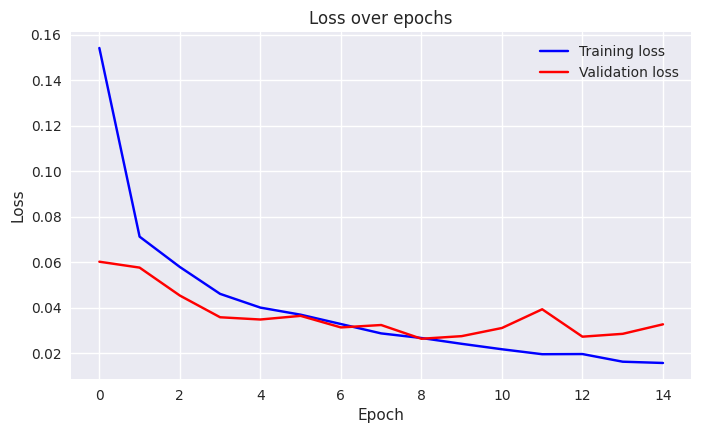

In [11]:
##########################
### 신경망 학습
##########################

model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, 
                                    valid_loader, N_EPOCHS, DEVICE)